In [25]:
%pwd
%matplotlib inline

# Import necessary libraries
# neccasary packages are loaded
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import zipfile
from IPython.display import display, Markdown
from ast import literal_eval
# import calendar
# from wordcloud import WordCloud
# import nltk
# nltk.download('brown')

import random

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# **Dataset cleaning and processing**
Lets start and load the dataset.

Few words about it:

The RecipeNLG dataset (Poznań University of Technology) is an expansion of the Recipe1M+ dataset, offering a significantly larger selection of recipes. Unlike its predecessor, this dataset does not prioritize linking cooking instructions with their corresponding images and instead emphasizes the recipe text, structure, and logic. This updated collection contains over one million newly preprocessed and deduplicated recipes, making it the largest publicly accessible dataset in its field.

The data could be downloaded from Poznań University of Technology website.

In [26]:
dataset_path = "dataset/dataset_recipes.csv"
print(dataset_path)

df = pd.read_csv(dataset_path)
# df = pd.read_csv(Path("../input/recipenlg/dataset/full_dataset.csv"), 
#                  converters={"ingredients": literal_eval, "directions": literal_eval, "NER":literal_eval})

dataset/dataset_recipes.csv


## **List of columns**

In [27]:
df.columns

Index(['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source',
       'NER'],
      dtype='object')

The dataset consists of 7 columns:
- id (int): ID.
- title (str): Title of the recipe.
- ingredients (list of str): Ingredients.
- directions (list of str): Instruction steps.
- link (str): URL link.
- source (ClassLabel): Origin of each recipe record, with possible value {"Gathered", "Recipes1M"}:
    1. "Gathered" (0): Additional recipes gathered from multiple cooking web pages using automated scripts in a web scraping process.
    2. "Recipes1M" (1): Recipes from the "Recipe1M+" dataset.

## Column renaming

df.head(10)

In [28]:
df.rename(columns={'Unnamed: 0': 'ID','directions': 'procedure', 'title': 'name'},inplace=True, errors='raise')

## Data structure

In [29]:
df.head()

,ID,name,ingredients,procedure,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


## Setting the types

In [30]:
df = df.astype({'ID': int, 
                'name': str,
                'ingredients': 'object', 
                'procedure': 'object', 
                'link': str,
                'source': 'category', 
                'NER': 'object'})

## **Adding extra columns**
The variations in ingredients and their quantities across recipes, as well as the number of steps in each recipe, are of interest.


In [31]:
df['n_NER'] = df['NER'].apply(len)
df['n_procedures'] = df['procedure'].apply(len)

In [32]:
df.head()

,ID,name,ingredients,procedure,link,source,NER,n_NER,n_procedures
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu...",88,357
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom...",67,175
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar...",76,171
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo...",73,394
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu...",89,229


### **Cleaning empty**
First lets copy the df

In [33]:
df_old = df[:]

#### Cleaning n_NER column

In [34]:
df = df[df['n_NER'] > 0]

#### Cleaning n_procedures column

In [35]:
df = df[df['n_procedures'] > 0]

Dataset Head:
    ID                   name  \
0   0    No-Bake Nut Cookies   
1   1  Jewell Ball'S Chicken   
2   2            Creamy Corn   
3   3          Chicken Funny   
4   4   Reeses Cups(Candy)     

                                         ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                           procedure  \
0  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  ["Place chipped beef on bottom of baking dish....   
2  ["In a slow cooker, combine all ingredients. C...   
3  ["Boil and debone chicken.", "Put bite size pi...   
4  ["Combine first four ingredients and press in ...   

                                              link    source  \
0   www.cookbooks.com/Recipe-Details.aspx?id=44874  Ga

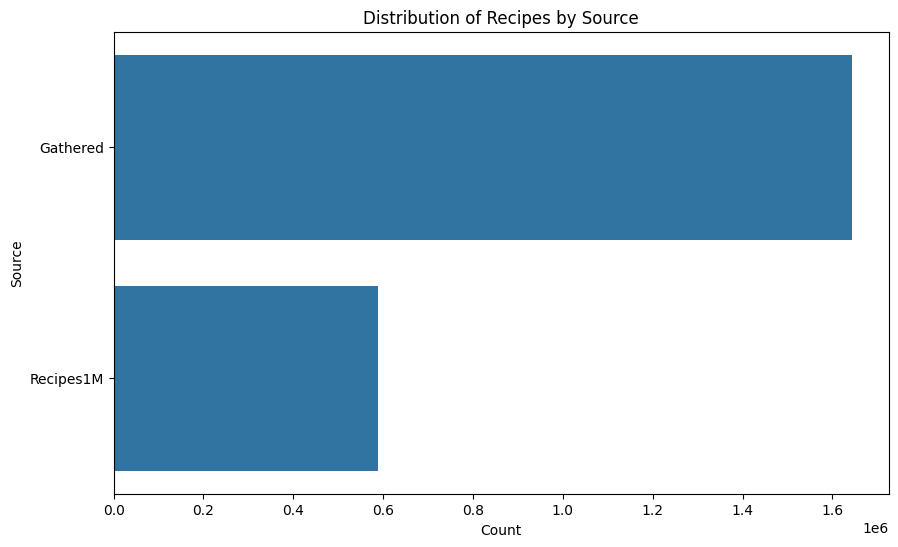

In [36]:
# Display the first few rows of the dataset
print("Dataset Head:\n", df.head())

# Display basic information about the dataset
print("\nDataset Info:\n")
df.info()

# Display summary statistics of the dataset
print("\nDataset Description:\n", df.describe())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Check for duplicates
print("\nDuplicate Rows:\n", df.duplicated().sum())

# Visualize distribution of recipes
plt.figure(figsize=(10, 6))
sns.countplot(y=df['source'])
plt.title('Distribution of Recipes by Source')
plt.xlabel('Count')
plt.ylabel('Source')
plt.show()


In [37]:
# Remove duplicate rows
df = df.drop_duplicates()

# Handling missing values
# For simplicity, we will drop rows with missing values. 
# Depending on the data, you may choose to impute missing values.
df = df.dropna()

# Verify that there are no more missing values or duplicates
print("\nMissing Values After Cleaning:\n", df.isnull().sum())
print("\nDuplicate Rows After Cleaning:\n", df.duplicated().sum())



Missing Values After Cleaning:
 ID              0
name            0
ingredients     0
procedure       0
link            0
source          0
NER             0
n_NER           0
n_procedures    0
dtype: int64

Duplicate Rows After Cleaning:
 0


### Tokenize Ingredients and Procedures for NLP Models

In [38]:
# Tokenizing only the ingredients
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['NER'])  # Use the NER column only. NER column contains the ingredients
ingredient_sequences = tokenizer.texts_to_sequences(df['NER'])
print(f"ingredient_sequences -> {ingredient_sequences[0:5]}")

# Calculate the length of each ingredient list
sequence_lengths = [len(seq) for seq in ingredient_sequences]

# Set max_sequence_length to a suitable value, e.g., 90th percentile
max_sequence_length = int(np.percentile(sequence_lengths, 90))

ingredient_sequences_padded = pad_sequences(ingredient_sequences, maxlen=max_sequence_length)


ingredient_sequences -> [[28, 2, 12, 15, 64, 4, 951, 863, 180, 43, 491], [37, 17, 106, 9, 50, 94, 40, 42, 9], [79, 48, 9, 6, 4, 10, 19, 1, 3], [17, 17, 464, 9, 50, 94, 40, 180, 6], [100, 4, 165, 161, 85, 4, 84, 2, 35, 66]]


In [39]:
# len(ingredient_sequences)
# df['NER'].unique
# # ingredient_sequences[0:10]

# NER_exploded = df.explode('NER')
# print(f"NER_explode len {len(NER_exploded)}")
# ingredients = NER_exploded['NER']
# print(ingredients[0:10])
# # get the unique values of the exploded column
# unique_NER_values = NER_exploded['NER'].unique()
# print(len(unique_NER_values))

In [40]:
NER_exploded = df.explode('NER')
# print(f"NER_explode len {len(NER_exploded)}")

ingredients = NER_exploded['NER']
# print(ingredients[0:10])

# get the unique values of the exploded column
unique_NER_values = NER_exploded['NER'].unique()
# print(len(unique_NER_values))

In [46]:
# Assume df is your DataFrame containing the 'ingredients' column
# For demonstration purposes, let's create a sample DataFrame with unique ingredients
# In your case, replace this with your actual DataFrame
# df = pd.read_csv('your_dataset.csv')  # Load your dataset

# Create a sample ingredients list (replace this with actual unique ingredients)
ingredients_list = unique_NER_values.tolist()  # Replace this with df['ingredients'].unique()

# Function to generate random ingredient combinations
def generate_random_combinations(ingredients_list, num_combinations=50000, max_ingredients_per_combination=5):
    combinations = []
    for _ in range(num_combinations):
        # Randomly select between 1 and max_ingredients_per_combination ingredients
        num_ingredients = random.randint(1, max_ingredients_per_combination)
        combination = random.sample(ingredients_list, num_ingredients)
        combinations.append(', '.join(combination))  # Join selected ingredients into a string
    return combinations

# Generate 50,000 user input combinations
user_input_combinations = generate_random_combinations(ingredients_list, num_combinations=50000)

# Example: Print the first 10 combinations
for i in range(10):
    print(user_input_combinations[i])


["eggs", "oil", "milk", "flour", "sugar", "salt", "poppy seed", "baking powder", "vanilla extract", "almond extract", "butter"]
["shrimp", "chicken stock", "butter", "okra", "onion", "green pepper", "clove garlic", "parsley", "thyme", "bay leaf", "tomatoes", "salt"], ["Hazelnut Cafe", "water", "accompaniments", "Chocolate", "'S ANGEL", "JET-PUFFED Miniature Marshmallows", "cinnamon sticks", "canes"], ["tomatoes", "garlic", "green peppers", "onions", "cooking oil", "tomato paste", "sugar", "salt", "basil", "oregano"], ["sugar", "cream cheese", "mashed ripe banana", "eggs", "baking mix", "walnuts", "Cooking spray"], ["No", "ground cinnamon", "honey", "vanilla", "yogurt", "splenda", "Lemon juice"]
["flour", "baking powder", "soda", "salt", "N", "shortening", "eggs", "nuts", "bananas"], ["goat cheese", "pinenuts", "tomatoes", "chicken", "I", "italian seasoned dry bread crumbs", "Vodka Sauce", "garlic", "pasta"], ["peeled apples", "eggs", "vanilla", "soda", "cinnamon", "nuts", "butter", "va

In [47]:
user_input_combinations_dict = {'user_input_simulated': user_input_combinations}
df_user_input_sim = pd.DataFrame(user_input_combinations_dict)
df_user_input_sim.to_csv('user_input_simulated.csv', index=False)

df_check = pd.read_csv('user_input_simulated.csv')
df_check.head()

,user_input_simulated
0,"[""eggs"", ""oil"", ""milk"", ""flour"", ""sugar"", ""sal..."
1,"[""shrimp"", ""chicken stock"", ""butter"", ""okra"", ..."
2,"[""flour"", ""baking powder"", ""soda"", ""salt"", ""N""..."
3,"[""ground pork"", ""hoisin sauce"", ""soy sauce"", ""..."
4,"[""cucumbers"", ""head cabbage"", ""onions"", ""salt""..."


In [48]:
embedding_dim = 300  # Size of the embedding vector
lstm_units = 128      # Number of LSTM units

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])



C:\Users\batoo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [53]:
# string representation of list to list using ast.literal_eval()
import ast

print(f"NER -> {df['NER'].head(5)}")

# Convert the string representation of lists to actual lists
df['ingredients_list'] = df['NER'].apply(ast.literal_eval)
print(f"ingredients_list -> {df['ingredients_list'].head(5)}")

# Convert the ingredients to a single string for each recipe
df['ingredients_str'] = df['ingredients_list'].apply(lambda x: ' '.join(x))
print(f"ingredients_str -> {df['ingredients_str'].head(5)}")

# # Fit a TF-IDF Vectorizer on the ingredients
# tfidf = TfidfVectorizer()
# tfidf_matrix = tfidf.fit_transform(df['ingredients_str'])

# # Function to compute similarity scores
# def compute_similarity(user_ingredients, tfidf, tfidf_matrix):
#     user_tfidf = tfidf.transform([user_ingredients])
#     cosine_sim = cosine_similarity(user_tfidf, tfidf_matrix)
#     return cosine_sim.flatten()

# # # Example user ingredients
# # user_ingredients = "chicken garlic onion salt pepper"
# # similarity_scores = compute_similarity(user_ingredients, tfidf, tfidf_matrix)


NER -> 0    ["brown sugar", "milk", "vanilla", "nuts", "bu...
1    ["beef", "chicken breasts", "cream of mushroom...
2    ["frozen corn", "cream cheese", "butter", "gar...
3    ["chicken", "chicken gravy", "cream of mushroo...
4    ["peanut butter", "graham cracker crumbs", "bu...
Name: NER, dtype: object
ingredients_list -> 0    [brown sugar, milk, vanilla, nuts, butter, bit...
1    [beef, chicken breasts, cream of mushroom soup...
2    [frozen corn, cream cheese, butter, garlic pow...
3    [chicken, chicken gravy, cream of mushroom sou...
4    [peanut butter, graham cracker crumbs, butter,...
Name: ingredients_list, dtype: object
ingredients_str -> 0    brown sugar milk vanilla nuts butter bite size...
1    beef chicken breasts cream of mushroom soup so...
2    frozen corn cream cheese butter garlic powder ...
3    chicken chicken gravy cream of mushroom soup s...
4    peanut butter graham cracker crumbs butter pow...
Name: ingredients_str, dtype: object


In [54]:
# Fit a TF-IDF Vectorizer on the ingredients
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['ingredients_str'])

# Function to compute similarity scores
def compute_similarity(user_ingredients, tfidf, tfidf_matrix):
    user_tfidf = tfidf.transform([user_ingredients])
    cosine_sim = cosine_similarity(user_tfidf, tfidf_matrix)
    return cosine_sim.flatten()

# Example user ingredients
user_ingredients = "chicken garlic onion salt pepper"
similarity_scores = compute_similarity(user_ingredients, tfidf, tfidf_matrix)


In [55]:
similarity_scores

array([0.        , 0.14644805, 0.31147986, ..., 0.03567376, 0.03907691,
       0.12303516])

In [58]:
# # Example hardcoded user ingredients
# hardcoded_user_inputs = [
#     "chicken, garlic, onion, salt, pepper",
#     "beef, carrots, potatoes, salt, pepper",
#     "tofu, soy sauce, ginger, garlic, scallions"
# ]

df_user_input = pd.read_csv('user_input_simulated.csv')
# Iterate over the loaded data to preprocess and compute similarity scores
for index, row in df_user_input.iterrows():
    user_ingredients = row['user_input_simulated']
    user_ingredients_list = [ingredient.strip() for ingredient in user_ingredients.split(',')]
    user_ingredients_str = ' '.join(user_ingredients_list)
    print(user_ingredients_str)
    
    # Compute similarity scores
    similarity_scores = compute_similarity(user_ingredients_str, tfidf, tfidf_matrix)

    # Print the similarity scores
    print(similarity_scores)


["eggs" "oil" "milk" "flour" "sugar" "salt" "poppy seed" "baking powder" "vanilla extract" "almond extract" "butter"]
[0.0821587  0.         0.11540357 ... 0.03237508 0.04219306 0.02588085]
["shrimp" "chicken stock" "butter" "okra" "onion" "green pepper" "clove garlic" "parsley" "thyme" "bay leaf" "tomatoes" "salt"] ["Hazelnut Cafe" "water" "accompaniments" "Chocolate" "'S ANGEL" "JET-PUFFED Miniature Marshmallows" "cinnamon sticks" "canes"] ["tomatoes" "garlic" "green peppers" "onions" "cooking oil" "tomato paste" "sugar" "salt" "basil" "oregano"] ["sugar" "cream cheese" "mashed ripe banana" "eggs" "baking mix" "walnuts" "Cooking spray"] ["No" "ground cinnamon" "honey" "vanilla" "yogurt" "splenda" "Lemon juice"]
[0.02864422 0.04484586 0.11220719 ... 0.01751095 0.07164775 0.12105833]
["flour" "baking powder" "soda" "salt" "N" "shortening" "eggs" "nuts" "bananas"] ["goat cheese" "pinenuts" "tomatoes" "chicken" "I" "italian seasoned dry bread crumbs" "Vodka Sauce" "garlic" "pasta"] ["pee

In [ ]:
# Assuming ingredient_sequences is your padded input for recipes
model.fit(ingredient_sequences_padded, similarity_scores, epochs=10, batch_size=32, validation_split=0.2)


### Data Augmentation: Generating Additional Features
To enhance the dataset and improve model performance, we will generate additional features such as ingredient frequency and procedure length.

1. Ingredient Frequency
Calculate the frequency of each ingredient appearing in the dataset.

2. Procedure Length
Calculate the length of each procedure in terms of the number of words.

In [ ]:
# Import necessary libraries
from collections import Counter
# import numpy as np

# Generate Ingredient Frequency Feature

# Flatten the list of all ingredients to calculate frequency
all_ingredients = [ingredient for sublist in df['ingredients_tokenized'] for ingredient in sublist]
ingredient_freq = Counter(all_ingredients)

# Create a column for ingredient frequency
df['ingredient_frequency'] = df['ingredients_tokenized'].apply(lambda x: np.mean([ingredient_freq[ingredient] for ingredient in x]))

# Example of ingredient frequency
print("\nIngredient Frequency:\n", df[['ingredients_tokenized', 'ingredient_frequency']].head())

# # Generate Procedure Length Feature

# # Create a column for procedure length
# df['procedure_length'] = df['procedure_tokenized'].apply(len)

# # Example of procedure length
# print("\nProcedure Length:\n", df[['procedure_tokenized', 'procedure_length']].head())

# Additional Feature: Number of Ingredients

# Create a column for the number of ingredients
df['num_ingredients'] = df['ingredients_tokenized'].apply(len)

# Example of number of ingredients
print("\nNumber of Ingredients:\n", df[['ingredients_tokenized', 'num_ingredients']].head())

# Display the dataframe with the new features
print("\nDataframe with New Features:\n", df.head())


### Embedding Representations with Pre-trained Models (Word2Vec and GloVe)
Using pre-trained embeddings such as Word2Vec and GloVe for ingredients and procedures can significantly improve the performance of your machine learning models. These embeddings capture the semantic relationships between words, providing rich context that can help the model understand the ingredients and procedures better.


#### Load Pre-trained Word2Vec and GloVe Embeddings

In [ ]:
# Import necessary libraries
import gensim.downloader as api
# import numpy as np

# Load pre-trained Word2Vec model (Google News vectors)
word2vec_model = api.load("word2vec-google-news-300")

# Load pre-trained GloVe model (Common Crawl vectors)
glove_vectors = api.load("glove-wiki-gigaword-300")

# Check the number of words in each model
print("Word2Vec model contains {} words".format(len(word2vec_model)))
print("GloVe model contains {} words".format(len(glove_vectors)))


#### Create Functions to Get Embeddings for Ingredients and Procedures

In [ ]:
# Function to get the embedding for a list of words using a specified model
def get_embedding(words, model, embedding_dim=300):
    # Initialize a zero vector of size equal to the embedding dimension (300 in this case)
    embedding = np.zeros((embedding_dim,))
    count = 0
    for word in words:
        if word in model:
            embedding += model[word]  # Add the word vector to the embedding
            count += 1
    if count > 0:
        embedding /= count  # Average the word vectors if there are valid words in the list
    return embedding

# Apply the function to get embeddings for ingredients and procedures
df['ingredients_embedding_w2v'] = df['ingredients_tokenized'].apply(lambda x: get_embedding(x, word2vec_model))
df['procedure_embedding_w2v'] = df['procedure_tokenized'].apply(lambda x: get_embedding(x, word2vec_model))

df['ingredients_embedding_glove'] = df['ingredients_tokenized'].apply(lambda x: get_embedding(x, glove_vectors))
df['procedure_embedding_glove'] = df['procedure_tokenized'].apply(lambda x: get_embedding(x, glove_vectors))

# Example of embeddings
print("\nWord2Vec Embedding for Ingredients:\n", df['ingredients_embedding_w2v'].head())
print("\nWord2Vec Embedding for Procedures:\n", df['procedure_embedding_w2v'].head())
print("\nGloVe Embedding for Ingredients:\n", df['ingredients_embedding_glove'].head())
print("\nGloVe Embedding for Procedures:\n", df['procedure_embedding_glove'].head())



#### Model Architecture for Recipe Recommendations - LSTM

In [ ]:
# Import necessary libraries
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Flatten
from keras.optimizers import Adam

# Define model parameters
embedding_dim = 300  # Dimensions of the pre-trained embeddings
lstm_units = 128  # Number of LSTM units
dense_units = 64  # Number of Dense layer units

# Define input layers
ingredients_input = Input(shape=(None, embedding_dim), name='ingredients_input')
procedure_input = Input(shape=(None, embedding_dim), name='procedure_input')

# LSTM layers
ingredients_lstm = LSTM(lstm_units, return_sequences=True)(ingredients_input)
procedure_lstm = LSTM(lstm_units, return_sequences=True)(procedure_input)

# Flatten the LSTM outputs
ingredients_flat = Flatten()(ingredients_lstm)
procedure_flat = Flatten()(procedure_lstm)

# Concatenate the LSTM outputs
concatenated = Concatenate()([ingredients_flat, procedure_flat])

# Dense layers
dense_1 = Dense(dense_units, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_1)

# Define the model
model = Model(inputs=[ingredients_input, procedure_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


# **Analysis**

## **Unique values for the sources**

In [17]:
df['source'].unique()

['Gathered', 'Recipes1M']
Categories (2, object): ['Gathered', 'Recipes1M']

## **Unique values for the recipes**

In [18]:
unique_names = len(df['name'].unique())
number_entries = len(df)
number_entries_old = len(df_old)
display(Markdown(f'Number of all entries: {number_entries:.0f} vs Number of all entries before cleaning: {number_entries_old :.0f}'))
display(Markdown(f'Number of unique names: {unique_names :.0f}'))

Number of all entries: 2231142 vs Number of all entries before cleaning: 2231142

Number of unique names: 1312871

## Distribution of number ingridients by sources

C:\Users\batoo\AppData\Local\Temp\ipykernel_7704\2558380749.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_n_ingridients = df.groupby('source')['n_NER'].mean()


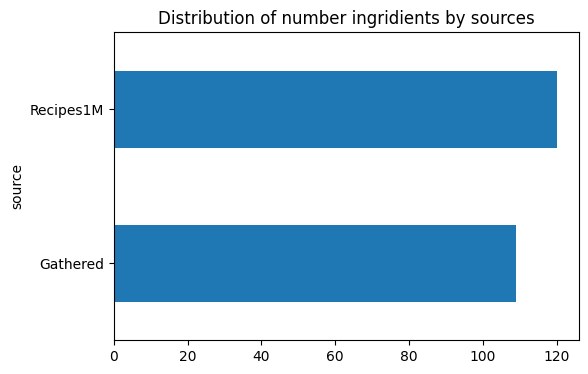

In [19]:
average_n_ingridients = df.groupby('source')['n_NER'].mean()
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of number ingridients by sources')
average_n_ingridients.plot(kind='barh', stacked=False, ax=ax)
# Show the chart
plt.show()

## **Distribution of number procedure steps by sources**

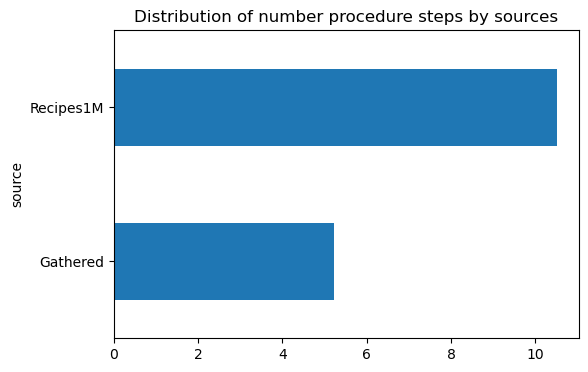

In [17]:
average_n_procedures = df.groupby('source')['n_procedures'].mean()
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of number procedure steps by sources')
average_n_procedures.plot(kind='barh', stacked=False, ax=ax)
# Show the chart
plt.show()

## Ingridients

In [20]:
NER_exploded = df.explode('NER')

### **List of ingridients**

In [21]:
ingridients = NER_exploded['NER']

In [22]:
# get the unique values of the exploded column
unique_NER_values = NER_exploded['NER'].unique()

In [23]:
display(Markdown(f'Number of unique ingridients: {len(unique_NER_values) :.0f}'))

Number of unique ingridients: 2133496

In [24]:
print(unique_NER_values[:200])

['["brown sugar", "milk", "vanilla", "nuts", "butter", "bite size shredded rice biscuits"]'
 '["beef", "chicken breasts", "cream of mushroom soup", "sour cream"]'
 '["frozen corn", "cream cheese", "butter", "garlic powder", "salt", "pepper"]'
 '["chicken", "chicken gravy", "cream of mushroom soup", "shredded cheese"]'
 '["peanut butter", "graham cracker crumbs", "butter", "powdered sugar", "chocolate chips"]'
 '["baking potatoes", "extra lean ground beef", "butter", "milk", "salt", "pepper", "Cheddar cheese", "bacon", "green onion", "sour cream"]'
 '["sugar", "butter", "egg", "buttermilk", "flour", "salt", "soda", "buttermilk", "rhubarb", "vanilla"]'
 '["cream-style corn", "whole kernel corn", "crackers", "egg", "butter", "pepper"]'
 '["tomatoes", "water", "onions", "Worcestershire sauce", "green peppers", "oil"]'
 '["pineapple", "condensed milk", "lemons", "pecans", "graham cracker crusts"]'
 '["dark sweet pitted cherries", "ginger ale", "flavor gelatin", "boiling water", "almond extr

There is an issue with the data, as it contains inconsistent naming conventions. For instance, "apples" should be "apple", and different types of cheese should be grouped into a single "cheese" category.



### **World cloud of ingridients**

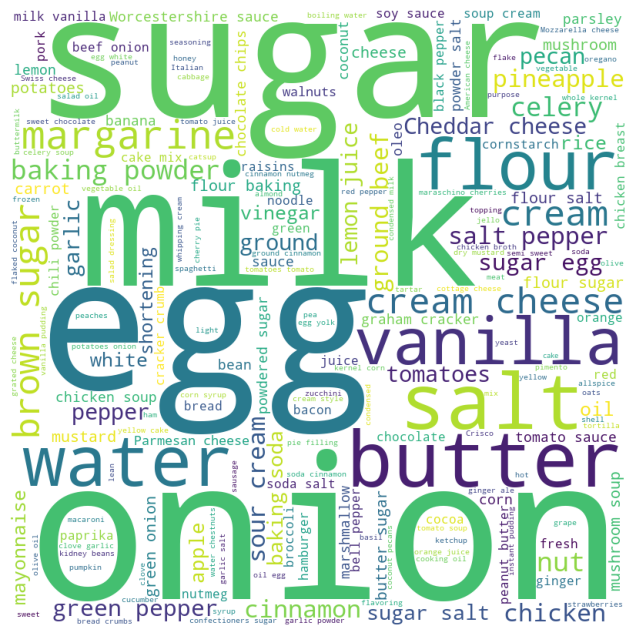

In [25]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(ingridients[:1000]))

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### **World cloud of unique ingridients**

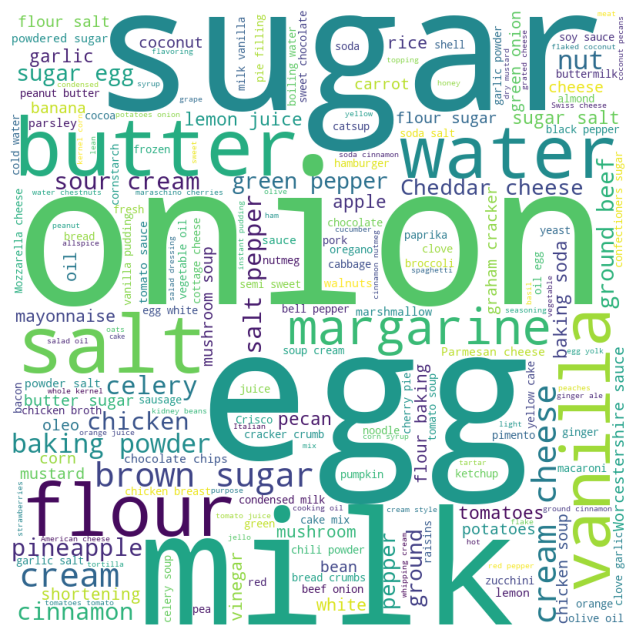

In [26]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(unique_NER_values[:1000]))

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()